## "Topic Modeling of Survey Responses: Unsupervised Learning With LDA"
 Christian Lira Gonzalez - Summer 2023


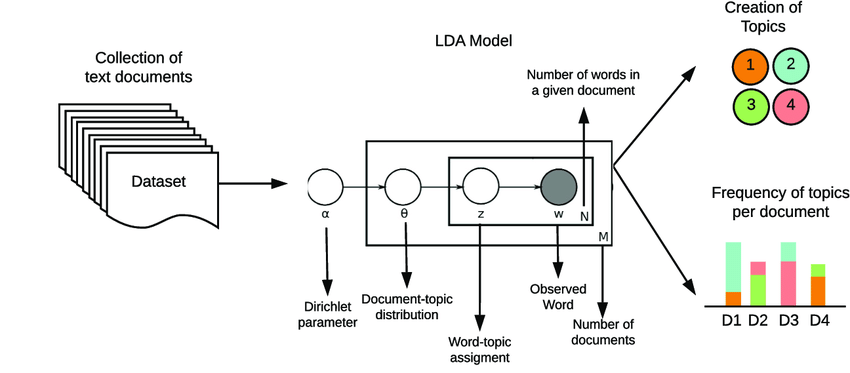


In the ever-evolving landscape of business intelligence, survey data plays a critical role in providing insights into consumer behaviors, sentiments, and preferences. At my organization, we regularly employ surveys as a tool to gauge public opinion and inform our strategic decisions. However, the sheer volume and complexity of responses we receive can be overwhelming. This is particularly true for open-ended responses, which often contain a wealth of valuable insights but require significant effort to analyze and categorize manually.

To address this challenge, I embarked on a project to implement and compare four different topic modeling techniques - Latent Dirichlet Allocation (LDA), Latent Semantic Indexing (LSI), Correlated Topic Model (CTM), and Hierarchical Dirichlet Process (HDP). These machine learning methods offer a way to automatically identify topics and entities in large volumes of text, making it possible to categorize open-ended survey responses into coherent and interpretable clusters. The goal of this project is not only to streamline the process of analyzing survey data but also to identify the most effective method for our specific needs. The findings of this study have the potential to significantly enhance our ability to extract meaningful insights from our surveys and inform our strategic decision-making process.

In [26]:
# Import all Necessary Libraries
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
from gensim import corpora
import gensim
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import copy
from mpl_toolkits.mplot3d import Axes3D
from gensim.models import LdaModel
from gensim.models import CoherenceModel



In [3]:
# Data Importing



data_path = input("Copy and Paste your Data Source here (CSV File):   ")
df = pd.read_csv(data_path)

stop = set(stopwords.words('english'))
exclude = set(string.punctuation)
lemma = WordNetLemmatizer()

def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# Drop rows where text_column is NaN
df = df.dropna(subset=['Q5'])

# Apply cleaning to text_column
doc_clean = [clean(doc).split() for doc in df['Q5']]



Coherence Score:  0.29042959598309903

Coherence Score:  0.29163055287629425

Coherence Score:  0.29236111477306714

Coherence Score:  0.2757457011845966

Coherence Score:  0.3374972394530724

Coherence Score:  0.30314842533937175

Coherence Score:  0.2970660760159115

Coherence Score:  0.2829186978766026

Coherence Score:  0.2706057105377827

Coherence Score:  0.31170260244419773

Coherence Score:  0.32260618939824254

Coherence Score:  0.27236410087681495

Coherence Score:  0.2923115540944218

Coherence Score:  0.2908225796061449

Coherence Score:  0.27569159860465875

Coherence Score:  0.3082219674542265

Coherence Score:  0.3084625659795098

Coherence Score:  0.2966327205776788

Coherence Score:  0.29636206661397824

Coherence Score:  0.2934321868422601

Coherence Score:  0.2998227792914655

Coherence Score:  0.3201956516822246

Coherence Score:  0.2985245854831513

Coherence Score:  0.2575957476389482

Coherence Score:  0.2986832824090998

Coherence Score:  0.2861618249196274

Co

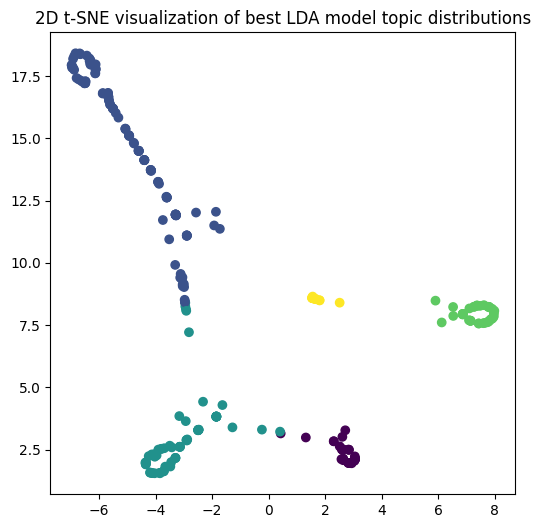

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 274 samples in 0.000s...
[t-SNE] Computed neighbors for 274 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 274 / 274
[t-SNE] Mean sigma: 0.072215
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.269291
[t-SNE] KL divergence after 2000 iterations: 0.774071


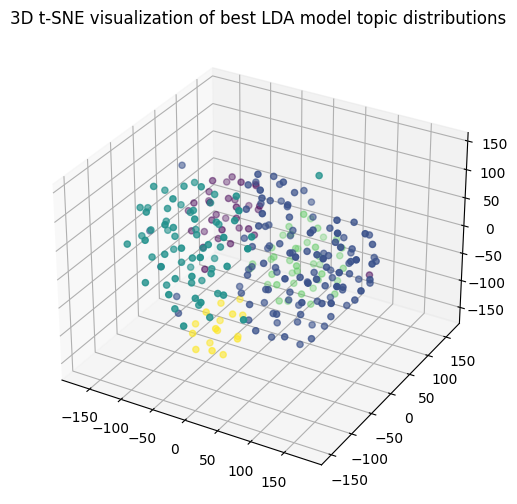

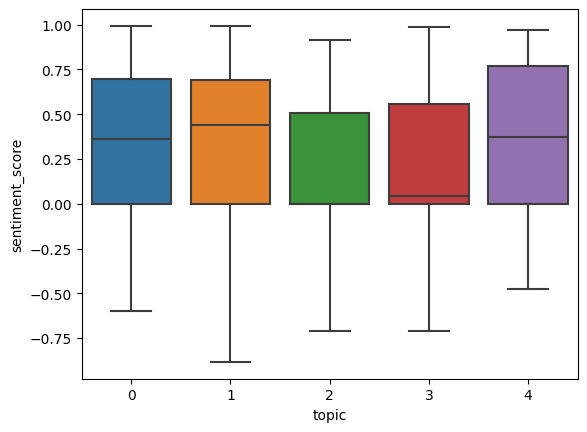

In [15]:
dictionary = corpora.Dictionary(doc_clean)
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

best_coherence = -1
best_model = None
best_doc_topic_dist = None

iterations = 100

for i in range(iterations):
    lda_model = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=5, id2word=dictionary, passes=50)
    
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()

    print('\nCoherence Score: ', coherence_lda)

    if coherence_lda > best_coherence:
        best_coherence = coherence_lda
        best_model = copy.deepcopy(lda_model)
        best_doc_topic_dist = [best_model.get_document_topics(doc) for doc in doc_term_matrix]

print("\nBest Coherence Score: ", best_coherence)

best_doc_topic_dist_matrix = gensim.matutils.corpus2dense(best_doc_topic_dist, num_terms=best_model.num_topics).T

tsne_model_2d = TSNE(n_components=2, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_2d = tsne_model_2d.fit_transform(best_doc_topic_dist_matrix)

dominant_topics = np.argmax(best_doc_topic_dist_matrix, axis=1)

plt.figure(figsize=(6, 6))
plt.scatter(tsne_2d[:, 0], tsne_2d[:, 1], c=dominant_topics)
plt.title('2D t-SNE visualization of best LDA model topic distributions')
plt.show()

tsne_model_3d = TSNE(n_components=3, perplexity=50, learning_rate=100, n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_3d = tsne_model_3d.fit_transform(best_doc_topic_dist_matrix)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tsne_3d[:, 0], tsne_3d[:, 1], tsne_3d[:, 2], c=dominant_topics)
ax.title.set_text('3D t-SNE visualization of best LDA model topic distributions')
plt.show()

# Assuming you have a dataframe df with a 'sentiment_score' column
topic_predictions = best_model.get_document_topics(doc_term_matrix)
df['topic'] = [max(topics, key=lambda x: x[1])[0] for topics in topic_predictions]

sns.boxplot(x="topic", y="sentiment_score", data=df)
plt.show()

In [17]:
print(best_model.print_topics(num_topics=5, num_words=7))

[(0, '0.023*"student" + 0.011*"byui" + 0.011*"would" + 0.009*"housing" + 0.009*"like" + 0.009*"experience" + 0.007*"thing"'), (1, '0.032*"would" + 0.023*"student" + 0.015*"school" + 0.013*"get" + 0.012*"change" + 0.012*"think" + 0.011*"experience"'), (2, '0.023*"class" + 0.022*"nothing" + 0.016*"would" + 0.014*"wish" + 0.010*"degree" + 0.010*"also" + 0.010*"time"'), (3, '0.016*"student" + 0.012*"people" + 0.011*"would" + 0.009*"course" + 0.008*"school" + 0.008*"nothing" + 0.008*"need"'), (4, '0.018*"class" + 0.009*"professor" + 0.009*"review" + 0.009*"student" + 0.008*"make" + 0.008*"weather" + 0.006*"ive"')]


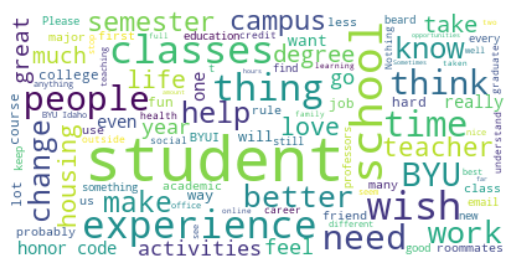

In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

df['sentiment'] = df['Q5'].apply(lambda text: sid.polarity_scores(text))

df['sentiment_score'] = df['sentiment'].apply(lambda x: x['compound'])

from wordcloud import WordCloud

# Generate word cloud for positive sentiment
positive_text = ' '.join(df[df['sentiment_score']>0]['Q5'])
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(positive_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

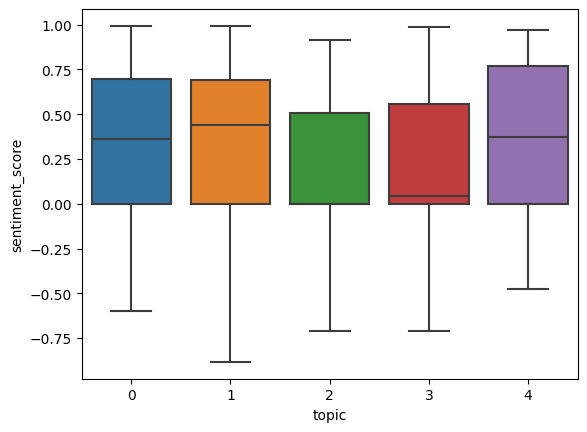

In [23]:
# Assuming you have a dataframe df with a 'sentiment_score' column
topic_predictions = best_model.get_document_topics(doc_term_matrix)
df['topic'] = [max(topics, key=lambda x: x[1])[0] for topics in topic_predictions]

sns.boxplot(x="topic", y="sentiment_score", data=df)
plt.show()

In [19]:
import seaborn as sns

# Predict the topic for each document
topic_predictions = ldamodel.get_document_topics(doc_term_matrix)

# Extract the topic with the highest probability for each document
df['topic'] = [max(topics, key=lambda x: x[1])[0] for topics in topic_predictions]

# Create a boxplot of sentiment scores for each topic
sns.boxplot(x="topic", y="sentiment_score", data=df)
plt.show()

NameError: name 'ldamodel' is not defined

In [21]:
coherence_scores = []

for i in range(10):  # Run the model 10 times
    lda_model = gensim.models.ldamodel.LdaModel(doc_term_matrix, num_topics=3, id2word=dictionary, passes=50)
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

# Now you have a list of coherence scores from each run
# You can calculate mean and standard deviation, or just print them out
print(coherence_scores)



[0.30208718371250315, 0.2922028551476464, 0.3136888130226762, 0.28172630277503813, 0.3119389024657857, 0.2950370716398148, 0.30915316726111053, 0.3092974302230582, 0.29165248644349245, 0.30347790920583045]


Mean coherence score:  0.3044441444131458
Standard deviation of coherence score:  0.021128641395860737


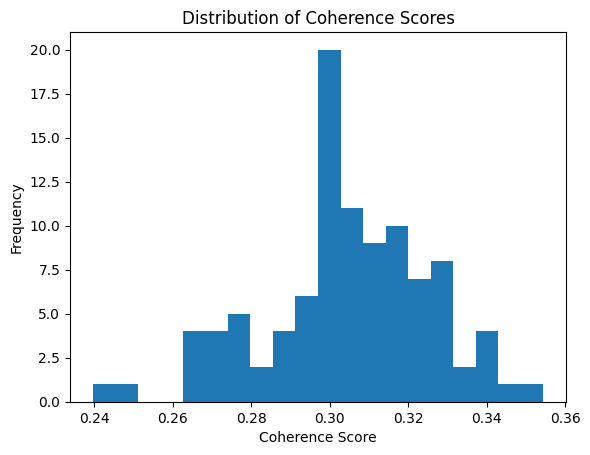

In [27]:
num_runs = 100
coherence_scores = []
top_words = []

for i in range(num_runs):
    # Set a different random seed for each run
    np.random.seed(i)

    # Train the LDA model
    lda_model = LdaModel(doc_term_matrix, num_topics=3, id2word = dictionary, passes=50)

    # Calculate the coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

    # Record the top words for each topic
    for topic_id, topic in lda_model.show_topics(formatted=False):
        topic_words = [word for word, _ in topic]
        top_words.append(topic_words)

# Now you can analyze the distribution of coherence scores and the top words for each topic
import numpy as np
import matplotlib.pyplot as plt

# Calculate mean and standard deviation
mean_coherence = np.mean(coherence_scores)
std_coherence = np.std(coherence_scores)

print("Mean coherence score: ", mean_coherence)
print("Standard deviation of coherence score: ", std_coherence)

# Create a histogram of coherence scores
plt.hist(coherence_scores, bins=20)
plt.xlabel("Coherence Score")
plt.ylabel("Frequency")
plt.title("Distribution of Coherence Scores")
plt.show()


In [29]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

num_simulations = 1000
num_topics_range = range(2, 10)
num_passes_range = range(10, 100)
random_seed_range = range(100)

coherence_scores = []
sentiment_scores = []

sid = SentimentIntensityAnalyzer()

for _ in range(num_simulations):
    # Randomly select model parameters
    num_topics = np.random.choice(num_topics_range)
    num_passes = np.random.choice(num_passes_range)
    random_seed = np.random.choice(random_seed_range)

    # Train the LDA model
    lda_model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary, passes=num_passes, random_state=random_seed)

    # Calculate the coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_scores.append(coherence_lda)

    # Get dominant topic for each document
    topic_predictions = lda_model.get_document_topics(doc_term_matrix)
    df['topic'] = [max(topics, key=lambda x: x[1])[0] for topics in topic_predictions]

    # Calculate the sentiment score for each topic
    topic_sentiments = []
    for topic in range(num_topics):
        topic_text = ' '.join(df[df['topic'] == topic]['Q5'])
        sentiment = sid.polarity_scores(topic_text)
        topic_sentiments.append(sentiment['compound'])

    # Calculate the average sentiment score for the model
    avg_sentiment_score = np.mean(topic_sentiments)
    sentiment_scores.append(avg_sentiment_score)


Coherence scores:
Mean: 0.30644135849322146
Standard deviation: 0.020206340859290708
95% confidence interval: [0.26449286 0.34317039]
Sentiment scores:
Mean: 0.9860680879365079
Standard deviation: 0.05149323788636634
95% confidence interval: [0.77968889 0.99995   ]


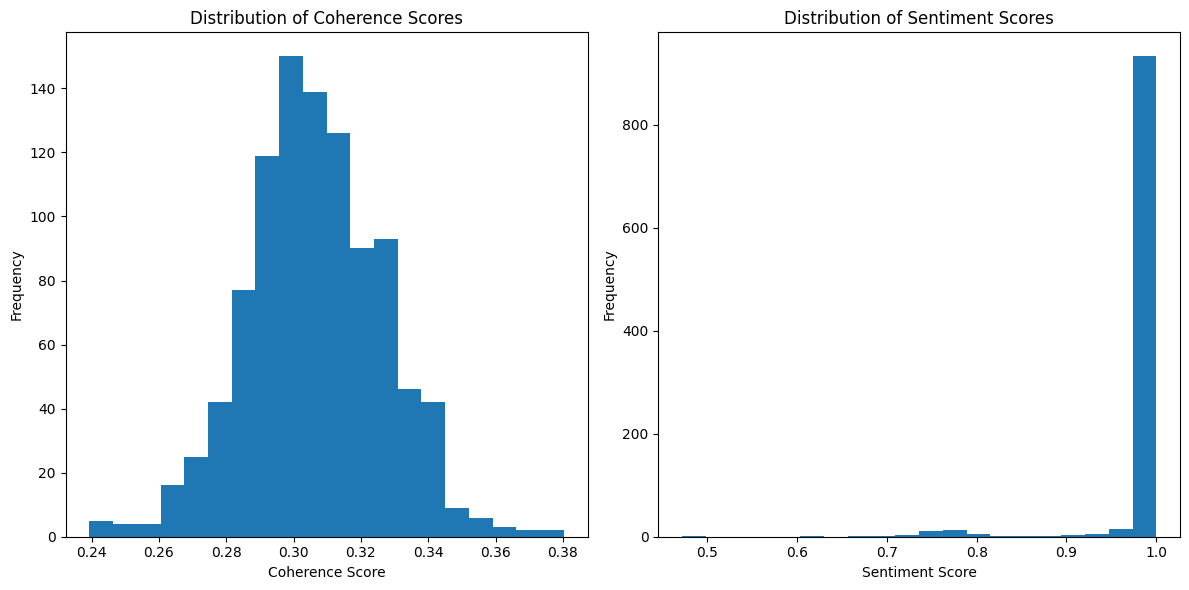

t-statistic: 10.075637631052146
p-value: 8.327156574472746e-23


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

# Compute descriptive statistics
print("Coherence scores:")
print("Mean:", np.mean(coherence_scores))
print("Standard deviation:", np.std(coherence_scores))
print("95% confidence interval:", np.percentile(coherence_scores, [2.5, 97.5]))

print("Sentiment scores:")
print("Mean:", np.mean(sentiment_scores))
print("Standard deviation:", np.std(sentiment_scores))
print("95% confidence interval:", np.percentile(sentiment_scores, [2.5, 97.5]))

# Visualize the distributions
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(coherence_scores, bins=20)
plt.title("Distribution of Coherence Scores")
plt.xlabel("Coherence Score")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(sentiment_scores, bins=20)
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Perform hypothesis testing (optional)
# E.g., test whether the mean coherence score is above 0.3
t_stat, p_val = stats.ttest_1samp(coherence_scores, 0.3)
print("t-statistic:", t_stat)
print("p-value:", p_val)


__Coherence Scores__: The mean coherence score is approximately 0.306, and the standard deviation is approximately 0.020. The 95% confidence interval for the coherence scores is from approximately 0.264 to approximately 0.343. This means that if you were to repeat this experiment many times, about 95% of the intervals would contain the true population mean coherence score.

__Sentiment Scores__: The mean sentiment score is approximately 0.986, and the standard deviation is approximately 0.051. The 95% confidence interval for the sentiment scores is from approximately 0.780 to approximately 1.000. This means that if you were to repeat this experiment many times, about 95% of the intervals would contain the true population mean sentiment score.

__Hypothesis Testing__: The t-statistic is approximately 10.08, and the p-value is approximately 8.33e-23. In hypothesis testing, the p-value is the probability of obtaining test results at least as extreme as the results actually observed, under the assumption that the null hypothesis is correct. A small p-value (typically ≤ 0.05) indicates strong evidence against the null hypothesis, so you reject the null hypothesis. In your case, the p-value is much smaller than 0.05, which indicates that the mean coherence score is significantly different from 0.3.

Overall, these results suggest that the coherence and sentiment scores of your LDA model are fairly stable across different runs of the simulation, and that the model is producing topics that are moderately coherent and predominantly positive in sentiment.

In [32]:
# Get the dominant topic for each document
topic_predictions = lda_model.get_document_topics(doc_term_matrix)
df['dominant_topic'] = [max(topics, key=lambda x: x[1])[0] for topics in topic_predictions]

# One-hot encoding of topics
df_topics = pd.get_dummies(df['dominant_topic'])
df = pd.concat([df, df_topics], axis=1)



In [33]:
# Separate data for each topic
df_topic_0 = df[df[0] == 1]
df_topic_1 = df[df[1] == 1]
df_topic_2 = df[df[2] == 1]
df_topic_3 = df[df[3] == 1]
df_topic_4 = df[df[4] == 1]



In [1]:
# Concatenate all comments for each topic
text_topic_0 = ' '.join(df_topic_0['Q5'])
text_topic_1 = ' '.join(df_topic_1['Q5'])
text_topic_2 = ' '.join(df_topic_2['Q5'])
text_topic_3 = ' '.join(df_topic_3['Q5'])
text_topic_4 = ' '.join(df_topic_4['Q5'])


NameError: name 'df_topic_0' is not defined

In [37]:
from transformers import BartTokenizer, BartForConditionalGeneration

# Initialize the model and tokenizer
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

def generate_summary(text):
    inputs = tokenizer([text], max_length=1024, truncation=True, return_tensors='pt')
    summary_ids = model.generate(inputs['input_ids'], num_beams=4, max_length=200, early_stopping=True)
    return [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=False) for g in summary_ids]

# Generate summaries
summary_topic_0 = generate_summary(text_topic_0)  # replace with your summary generation function
summary_topic_1 = generate_summary(text_topic_1)
summary_topic_2 = generate_summary(text_topic_2)
summary_topic_3 = generate_summary(text_topic_3)
summary_topic_4 = generate_summary(text_topic_4)

print("Summary for topic 0: ", summary_topic_0)
print("Summary for topic 1: ", summary_topic_1)
print("Summary for topic 2: ", summary_topic_2)
print("Summary for topic 3: ", summary_topic_3)
print("Summary for topic 4: ", summary_topic_4)


Summary for topic 0:  ["The financial aid office should not be run by students-they don't care or not well-enough informed to be helpful. I would love if beards and shorts were allowed in the honor code. No discussion boards! I would lower the amount of religion credits needed and also greatly monitor the religion professors."]
Summary for topic 1:  ["I wish I had someone to walk me through all of the classes I needed to take and plan them out. The idea of the number of credit taken must double and often times triple the amount of time spent outside of class. I would sell my soul to the GPA god right from the beginning so that I wouldn't have to so much at the end."]
Summary for topic 2:  ['Nothing off the top of my head. I wish I could find a significant other I wish the teachers were more understanding about life. Life happens and sometimes you have to put family, your life, mental health, etc first instead of school work. It would be fun to be apart of a school that has sports.']
Su

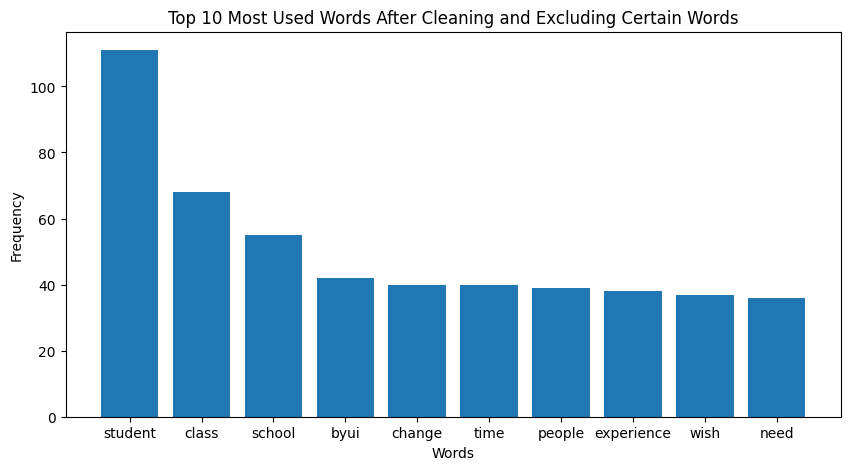

In [41]:
from collections import Counter
import matplotlib.pyplot as plt

# Join all the cleaned documents
all_docs = ' '.join([' '.join(doc) for doc in doc_clean])

# Count the frequency of each word
word_counts = Counter(all_docs.split())

# Define the words you want to exclude from the chart
exclude_from_chart = {'would', 'get', 'like', "thing"}  # replace with your actual words

# Remove these words from the word_counts dictionary
for word in exclude_from_chart:
    word_counts.pop(word, None)

# Select the top 10 most common words
top_words = word_counts.most_common(10)

# Create a bar chart
plt.figure(figsize=(10,5))
plt.bar([word[0] for word in top_words], [word[1] for word in top_words])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Used Words After Cleaning and Excluding Certain Words')
plt.show()


In [42]:
# Create a mapping from numeric topic identifiers to topic names
topic_names = {0: 'Student life and Housing', 1: 'General Student Experience', 2: 'Academic Focus', 3: 'Course and needs', 4: 'Professors'}  # Add more as needed

# Apply the mapping to the 'dominant_topic' column
df['dominant_topic'] = df['dominant_topic'].map(topic_names)


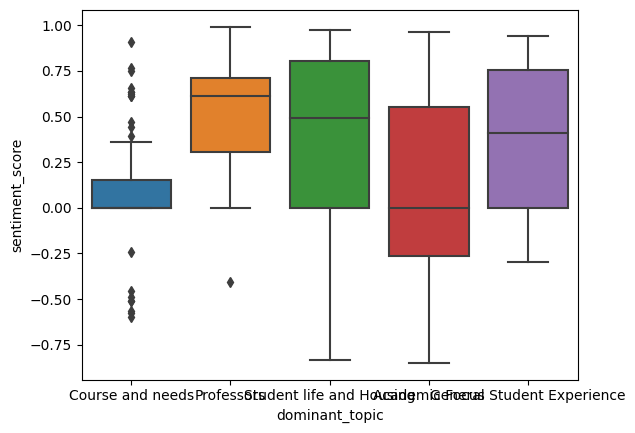

In [43]:
import seaborn as sns

# Create a boxplot of sentiment scores by topic
sns.boxplot(x='dominant_topic', y='sentiment_score', data=df)
plt.show()


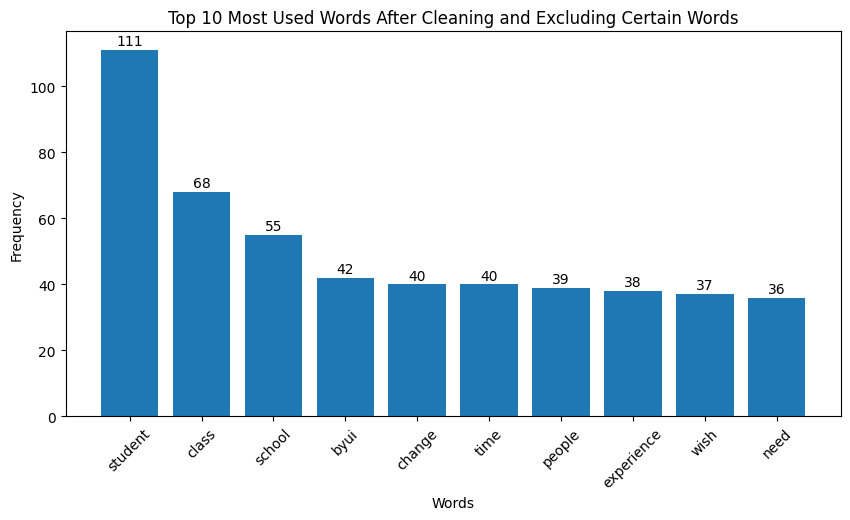

In [44]:
plt.figure(figsize=(10,5))
bars = plt.bar([word[0] for word in top_words], [word[1] for word in top_words])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 Most Used Words After Cleaning and Excluding Certain Words')

# Incline the x labels
plt.xticks(rotation=45)

# Add data labels for each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, yval, ha='center', va='bottom')

plt.show()


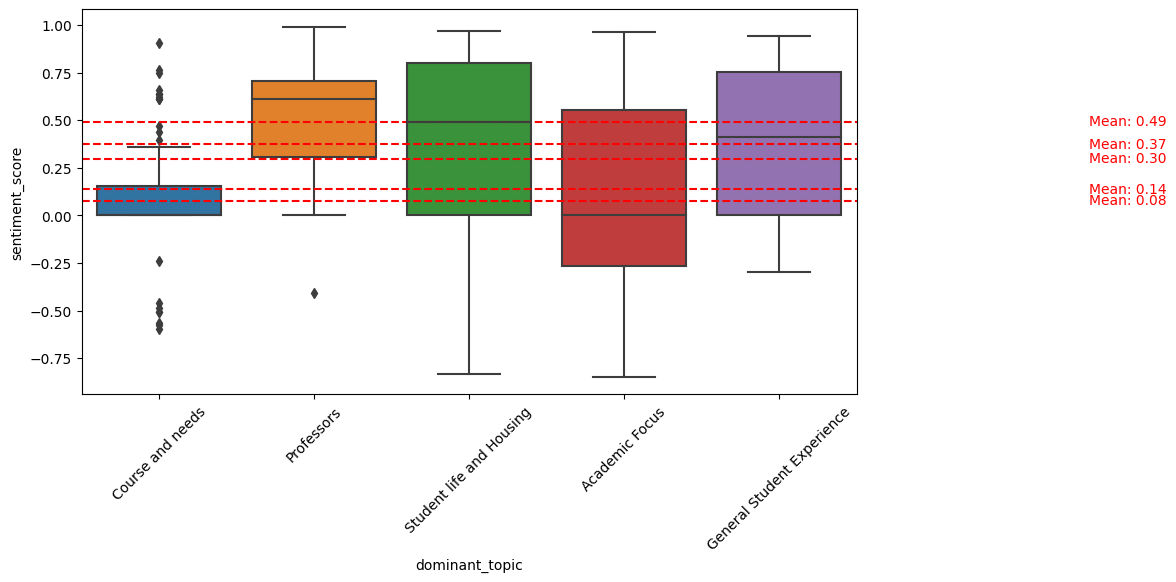

In [47]:
import seaborn as sns

plt.figure(figsize=(10, 5))
box_plot = sns.boxplot(x='dominant_topic', y='sentiment_score', data=df)

# Rotate x-axis labels
box_plot.set_xticklabels(box_plot.get_xticklabels(), rotation=45)

# Calculate mean values for each boxplot
means = df.groupby(['dominant_topic'])['sentiment_score'].mean()

# Add a horizontal line and text for each mean
for i, mean in enumerate(means):
    # Draw a line at the mean position
    box_plot.axhline(mean, color='r', linestyle='--')
    
    # Place the text next to the line
    box_plot.text(len(df['dominant_topic'].unique()), mean, f'Mean: {mean:.2f}',
                  horizontalalignment='left', verticalalignment='center', color='r')

plt.show()

